## Import

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from skimage import measure
import prepare_sub_image as ps
import matplotlib.pyplot as plt
import PIL.Image as pilimg
import math
import cv2
import numpy as np
from scipy import io
from collections import defaultdict

## Metrics

In [2]:
def ssim(target, ref):
    target_data = np.array(target)
    ref_data = np.array(ref)
    
    (score, diff) = measure.compare_ssim(target_data, ref_data, full = True, multichannel=True)
    
    return score

def psnr(target, ref):
    
    target_data = np.array(target, dtype = float)
    ref_data = np.array(ref, dtype = float)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    
    rmse = math.sqrt(np.mean(diff**2))
    
    return 20 * math.log10(255/rmse)

## Model

In [3]:
def residual_model(x, filters_in, filters_out, k_size):

    input_img = x
    
    x = layers.Conv2D(filters_in, kernel_size = (k_size, k_size), strides = (1,1), padding = 'same', 
                      bias_initializer = 'zeros', kernel_initializer = 'glorot_uniform',
                      input_shape = (None, None, 1))(x)
    x = layers.ReLU()(x)
    
    for i in range(18):
        x = layers.Conv2D(filters_in, kernel_size = (k_size, k_size), strides = (1,1), padding = 'same', 
                          kernel_initializer = 'glorot_uniform', bias_initializer = 'zeros')(x)
        x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters_out, kernel_size = (k_size, k_size), strides = (1,1), padding = 'same', 
                      kernel_initializer = 'glorot_uniform', bias_initializer = 'zeros')(x)

    network_img = x
    
    output_img = layers.add([network_img, input_img])
    
    VDSR = Model(inputs = input_img, outputs = output_img)

    VDSR.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_squared_error'])
    
    return VDSR

In [4]:
def adjust_learning_rate(epoch):
    
    initial_lrate = 0.00001
    drop = 0.1
    epochs_drop = 20
    
    lr = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    return lr

## Train & Predict

In [ ]:
conv_side = 8
scale = 2
test_set = 'Set5'
#total_history = defaultdict(list)


def train():
    
    in1 = layers.Input(shape = (None, None, 1))
    
    vdsr_model = residual_model(x = in1, filters_in = 64, filters_out = 1, k_size = 3)    
    
    print(vdsr_model.summary())
    
    vdsr_model.load_weights('checkpoint/VDSR_checkpoint_291aug.h5')    
    
    '''
    data, label = ps.read_training_data('training_sample/train_291aug_new.h5')
    val_data, val_label = ps.read_training_data('training_sample/cross_val_BSD200_new.h5')    
    '''
    
    PATH_image = '../Dataset/test/test_mat/{}/scale{}/'.format(test_set, scale)
    IMAGE_PATH = 'output_image/{}/scale{}/'.format(test_set, scale)
    
    names_image = os.listdir(PATH_image)
    names_image = sorted(names_image)
    
    nums = len(names_image)
    
    count = 0
    global total_history
    
    checkpoint_filepath = 'checkpoint/VDSR_checkpoint_291aug_new.h5'
    checkpoint_callbacks = [ModelCheckpoint(filepath = checkpoint_filepath, monitor = 'val_loss', verbose = 1, mode = 'min', 
                                            save_best_only = True), LearningRateScheduler(adjust_learning_rate)]
    
    for i in range(0, 1):
        
        '''
        vdsr_model.fit(x = data, y = label, batch_size = 64, epochs = 2, verbose = 1,
                       callbacks = checkpoint_callbacks, validation_data = (val_data, val_label), shuffle = True)
        '''
        
        count += 1
        
        psnr_vdsr = []
        psnr_bicubic = []
        ssim_vdsr = []
        ssim_bicubic = []
        
        for i in range(nums):
            
            INPUT_NAME = IMAGE_PATH + '/' + 'input{}.jpg'.format(i)
            OUTPUT_NAME = IMAGE_PATH + '/' + 'predict{}.jpg'.format(i)
            
            mat_image = io.loadmat(PATH_image + names_image[i])
            
            hr_img = mat_image['im_hr_ycbcr']
            bicubic_img = mat_image['im_bicubic_ycbcr']
            
            hr_img_Y = hr_img[:, :, 0]
            bicubic_img_Y = bicubic_img[:, :, 0]
            
            hr_img_rgb = mat_image['im_hr_rgb']
            bicubic_img_rgb = mat_image['im_bicubic_rgb']

            shape = bicubic_img.shape
            
            input_Y = np.zeros([1, shape[0], shape[1], 1])
            input_Y[0, :, :, 0] = bicubic_img_Y / 255
            
            
            pre = vdsr_model.predict(input_Y, batch_size = 1)
            pre = pre * 255
            pre[pre[:] > 255] = 255
            pre[pre[:] < 0] = 0
            
            
            output_img = np.zeros([shape[0], shape[1], 3])
            output_img[:, :, 0] = pre[0, :, :, 0]
            output_img[:, :, 2] = bicubic_img[:, :, 1]
            output_img[:, :, 1] = bicubic_img[:, :, 2]
            
            output_img_Y = output_img[:, :, 0]
                        
            output_BGR = np.zeros([shape[0], shape[1], 3])
            
            output_BGR[:, :, 2] = 1.164 * (output_img[:, :, 0] - 16) + 1.596 * (output_img[:, :, 1] - 128)
            output_BGR[:, :, 1] = 1.164 * (output_img[:, :, 0] - 16) - 0.813 * (output_img[:, :, 1] - 128) - 0.392 * (output_img[:, :, 2] - 128)
            output_BGR[:, :, 0] = 1.164 * (output_img[:, :, 0] - 16) + 2.017 * (output_img[:, :, 2] - 128)
            
            cv2.imwrite(OUTPUT_NAME, output_BGR)
            
            '''
            # Measuring PSNR on RGB Channel
            output_img_rgb = np.zeros([shape[0], shape[1], 3])
            output_img_rgb[:, :, 0] = 1.164 * (output_img[:, :, 0] - 16) + 1.596 * (output_img[:, :, 1] - 128)
            output_img_rgb[:, :, 1] = 1.164 * (output_img[:, :, 0] - 16) - 0.813 * (output_img[:, :, 1] - 128) - 0.392 * (output_img[:, :, 2] - 128)
            output_img_rgb[:, :, 2] = 1.164 * (output_img[:, :, 0] - 16) + 2.017 * (output_img[:, :, 2] - 128)            
            '''
            
            # Measuring PSNR on YCrCb Channel
            hr_img_measure = hr_img_Y[conv_side:-conv_side, conv_side:-conv_side]
            bicubic_img_measure = bicubic_img_Y[conv_side:-conv_side, conv_side:-conv_side]
            output_img_measure = output_img_Y[conv_side:-conv_side, conv_side:-conv_side]
            
            '''
            # Measuring PSNR on RGB Channel
            hr_img_measure = hr_img_rgb[conv_side:-conv_side, conv_side:-conv_side, :]
            bicubic_img_measure = bicubic_img_rgb[conv_side:-conv_side, conv_side:-conv_side, :]
            output_img_measure = output_img_rgb[conv_side:-conv_side, conv_side:-conv_side, :]
            '''
            
            psnr_bicubic_one = psnr(bicubic_img_measure, hr_img_measure)
            ssim_bicubic_one = ssim(bicubic_img_measure, hr_img_measure)
            
            psnr_vdsr_one = psnr(output_img_measure, hr_img_measure)
            ssim_vdsr_one = ssim(output_img_measure, hr_img_measure)
            
            print(i + 1)
            print('BICUBIC: ', psnr_bicubic_one, 'ssim: ', ssim_bicubic_one)
            print('VDSR: ', psnr_vdsr_one, 'ssim: ', ssim_vdsr_one)
            
            psnr_bicubic.append(psnr_bicubic_one)
            ssim_bicubic.append(ssim_bicubic_one)
            
            psnr_vdsr.append(psnr_vdsr_one)
            ssim_vdsr.append(ssim_vdsr_one)
            
            
        psnr_bicubic_final = np.mean(psnr_bicubic)
        ssim_bicubic_final = np.mean(ssim_bicubic)
        
        psnr_vdsr_final = np.mean(psnr_vdsr)
        ssim_vdsr_final = np.mean(ssim_vdsr)
        
        print('Epochs: ', count * 1 )
        
        print('Bicubic')
        print('PSNR: ', psnr_bicubic_final, 'SSIM: ', ssim_bicubic_final)
        print('VDSR')
        print('PSNR: ', psnr_vdsr_final, 'SSIM: ', ssim_vdsr_final)
        
        
        '''
        for key, value in history.history.items():

            total_history[key] = sum([total_history[key], history.history[key]], [])

            
        length = len(total_history['loss'])

        plt.plot(total_history['loss'])
        plt.plot(total_history['val_loss'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        #plt.xticks(ticks = 1)
        plt.xlim(9, length)
        plt.ylim(0, 0.003)
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        '''
    
    
if __name__ == '__main__':
    
    
    train()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 640         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, None, None, 6 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       re_lu[0][0

##  Visualization

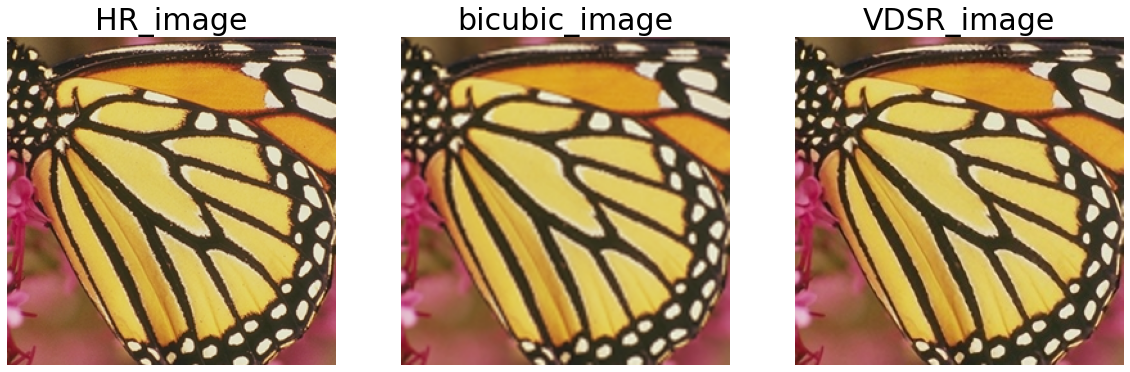

In [14]:
def visualization():
    
    hr_img = pilimg.open('../Dataset/test/test_image/{}/hr_rgb/scale{}/hr_RGB_{}_3.bmp'.format(test_set, scale, scale))
    pix_hr = np.array(hr_img)
    
    bicubic_img = pilimg.open('../Dataset/test/test_image/{}/bicubic_rgb/scale{}/bicubic_RGB_{}_3.bmp'.format(test_set, scale, scale))
    pix_bicubic = np.array(bicubic_img)
    
    vdsr_img = pilimg.open('output_image/{}/scale{}/predict2.jpg'.format(test_set, scale))
    pix_srcnn = np.array(vdsr_img)
    
    fig = plt.figure(figsize = (20,32))
    rows = 1
    cols = 3
    
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(hr_img)
    ax1.set_title('HR_image', size = 30)
    ax1.axis('off')
    
    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(bicubic_img)
    ax2.set_title('bicubic_image', size = 30)
    ax2.axis('off')
    
    ax3 = fig.add_subplot(rows, cols, 3)
    ax3.imshow(vdsr_img)
    ax3.set_title('VDSR_image', size = 30)
    ax3.axis('off')
    
    plt.show()
    
    
if __name__ == '__main__':
    
    
    visualization()